## 1. Setting up the environment

In [1]:
import numpy as np
import gym

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
# setting manual seed
torch.manual_seed(0)

#matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# imports for rendering outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

In [3]:
# lets set up the cartpole environment
env = gym.make('CartPole-v0')
env.seed(0)

# lets find about the action and state space
print("Action space: {} ... State space: {}".format(env.action_space,env.observation_space))

Action space: Discrete(2) ... State space: Box(4,)


In [4]:
# lets play a random episode

# reset env
state = env.reset()
step_count = 0
done = False

while (not done):
    # random action
    action = env.action_space.sample()
    # taking step in env
    next_state,reward,done,_ = env.step(action)
    
    # displaying progress
    print ("Step : {} ... state: {} ... action: {} ... reward: {} ... done: {}".format(step_count,
                                                                                       state,action,reward,done))
    
    # updating state and step count
    state = next_state
    step_count+=1

Step : 0 ... state: [-0.04456399  0.04653909  0.01326909 -0.02099827] ... action: 0 ... reward: 1.0 ... done: False
Step : 1 ... state: [-0.04363321 -0.14877061  0.01284913  0.2758415 ] ... action: 1 ... reward: 1.0 ... done: False
Step : 2 ... state: [-0.04660862  0.04616568  0.01836596 -0.01276126] ... action: 1 ... reward: 1.0 ... done: False
Step : 3 ... state: [-0.04568531  0.24101949  0.01811073 -0.2995934 ] ... action: 0 ... reward: 1.0 ... done: False
Step : 4 ... state: [-0.04086492  0.04564414  0.01211887 -0.00125416] ... action: 1 ... reward: 1.0 ... done: False
Step : 5 ... state: [-0.03995204  0.24059021  0.01209378 -0.29008894] ... action: 1 ... reward: 1.0 ... done: False
Step : 6 ... state: [-0.03514023  0.43553764  0.006292   -0.57893321] ... action: 1 ... reward: 1.0 ... done: False
Step : 7 ... state: [-0.02642948  0.63057085 -0.00528666 -0.8696274 ] ... action: 1 ... reward: 1.0 ... done: False
Step : 8 ... state: [-0.01381806  0.82576432 -0.02267921 -1.16396778] ..

## 2. Defining the policy

In [5]:
# defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("using",device)

using cpu


In [6]:
class Policy(nn.Module):
    
    def __init__(self,state_size=4,hidden_size=16,action_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,action_size)
    
    def forward(self,state):
        net = F.relu(self.fc1(state))
        net = F.softmax(self.fc2(net),dim=-1)
        return net
    
    def act(self,state):
        # converting state from numpy array to pytorch tensor on the "device"
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        prob_dist = Categorical(probs)
        action = prob_dist.sample()
        return action.item(),prob_dist.log_prob(action)

## 3. Defining the RL agent

In [7]:
from collections import deque

class Agent:
    
    def __init__(self,env,learning_rate=1e-3):
        self.env = env
        self.env.seed(0)
        nS = env.observation_space.shape[0]
        nA = env.action_space.n
        self.policy = Policy(state_size=nS,hidden_size=16,action_size=nA).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
    
    def train(self,max_num_eps=1000,horizon=1000,gamma=1.0,PRINT_EVERY=100):
        scores = []
        scores_window = deque(maxlen=100)
        for eps_count in range(1,max_num_eps+1):
            # resetting state
            state = env.reset()
            total_reward = 0
            log_prob_list = []
            
            # playing an episode
            for t in range(horizon): 
                action,log_prob = self.policy.act(state)
                next_state,reward,done,_ = self.env.step(action)
                total_reward += reward*(gamma**t)
                
                # update state
                state = next_state
                log_prob_list.append(log_prob)
                
                # break if done
                if done:
                    break
            
            # computing loss and applying gradient
            loss_list = [-total_reward*log_prob for log_prob in log_prob_list]
            loss = torch.cat(loss_list).sum()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # updating scores and score_window
            scores.append(total_reward)
            scores_window.append(total_reward)
            
            #printing progress
            if eps_count % PRINT_EVERY == 0:
                print ("Episode: {} ... Avg reward: {:.2f}".format(eps_count,np.mean(scores_window))) 
            
            if np.mean(scores_window)>=195.0:
                print ("Environment solved in {} episodes! ... Avg reward : {:.2f}".format(eps_count-100,
                                                                                          np.mean(scores_window)))
                break
                
        return scores

## 4. Training the agent!

In [8]:
# lets define and train our agent
agent = Agent(env,learning_rate=1e-2)
scores = agent.train()

Episode: 100 ... Avg reward: 34.47
Episode: 200 ... Avg reward: 66.26
Episode: 300 ... Avg reward: 87.82
Episode: 400 ... Avg reward: 72.83
Episode: 500 ... Avg reward: 172.00
Episode: 600 ... Avg reward: 160.65
Episode: 700 ... Avg reward: 167.15
Environment solved in 691 episodes! ... Avg reward : 196.69


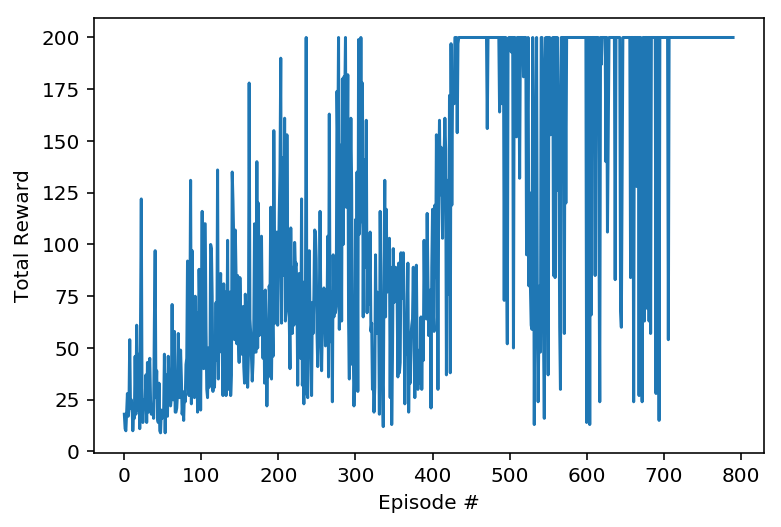

In [10]:
# plot reward curve over episodes
plt.figure()
plt.plot(scores)
plt.xlabel('Episode #')
plt.ylabel('Total Reward')
plt.show()

In [11]:
# save the policy
torch.save(agent.policy, 'REINFORCE.policy')

# load policy
# polciy =  torch.load('REINFORCE.policy')
# agent = Agent()
# agent.policy = policy

/Users/jsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## 5. Watch the smart agent!

In [15]:
# function to animate a list of frames
def animate_frames(frames):
    plt.figure(dpi = 72)
    plt.axis('off')

    # color option for plotting
    # use Greys for greyscale
    cmap = None if len(frames[0].shape)==3 else 'Greys'
    patch = plt.imshow(frames[0], cmap=cmap)  

    fanim = animation.FuncAnimation(plt.gcf(), \
        lambda x: patch.set_data(frames[x]), frames = len(frames), interval=30)
    
    display(display_animation(fanim, default_mode='once'))


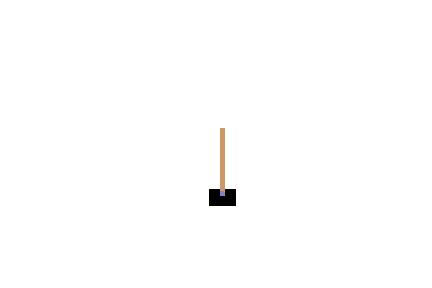
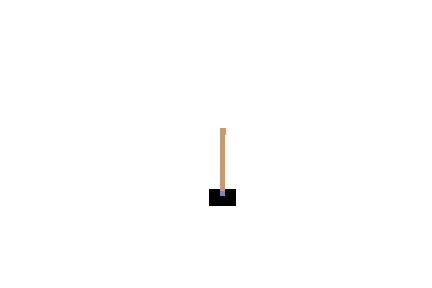
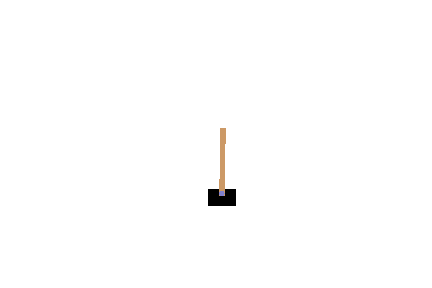
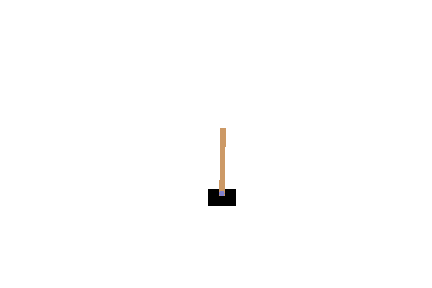
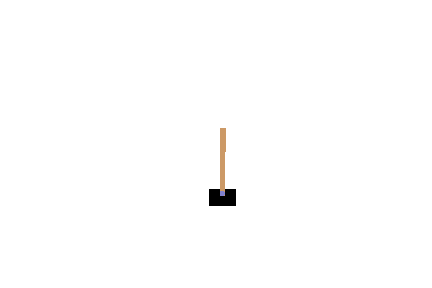
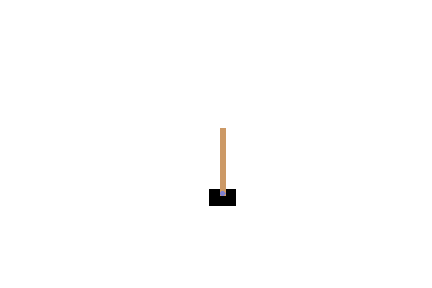
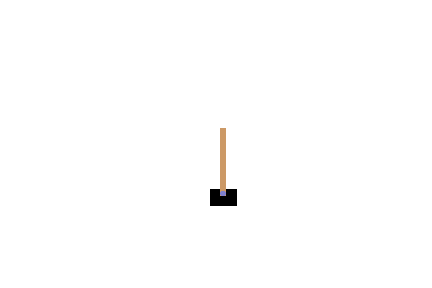
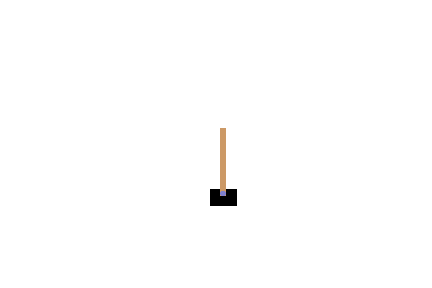
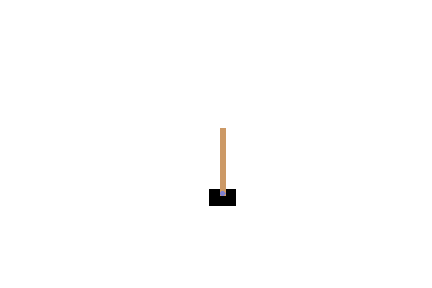
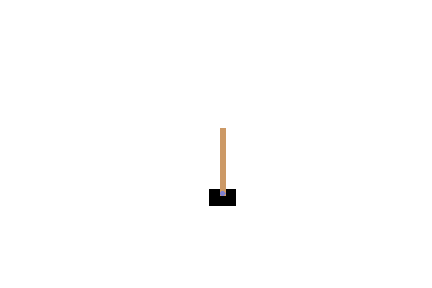
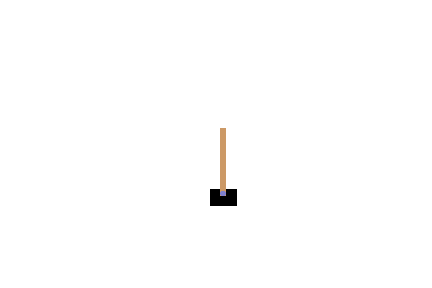
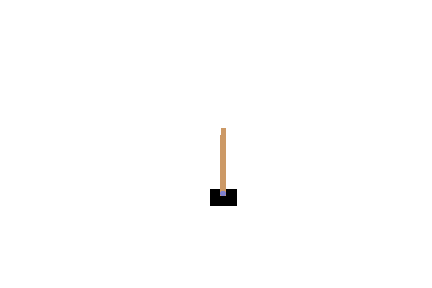
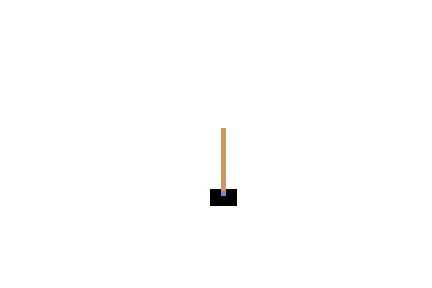
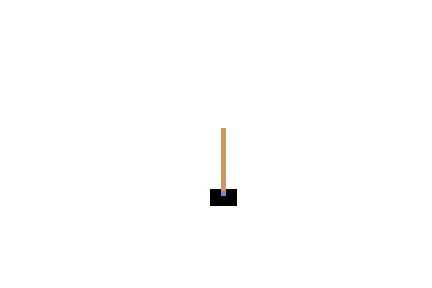
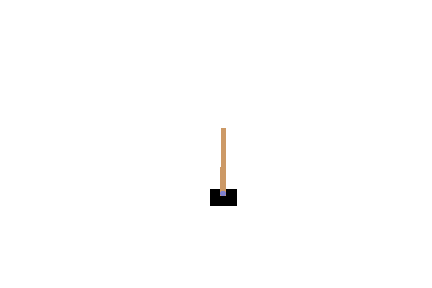
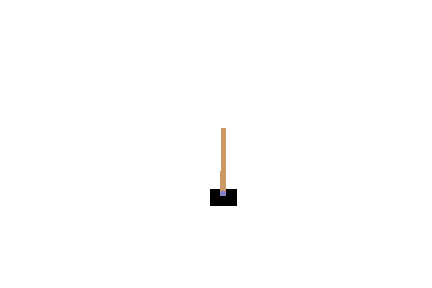
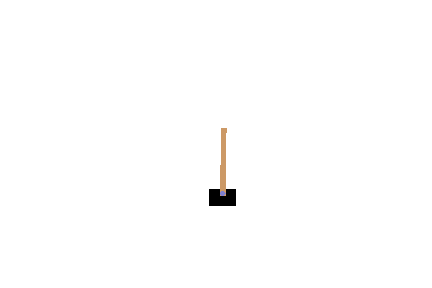
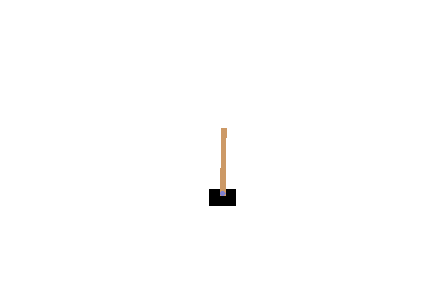
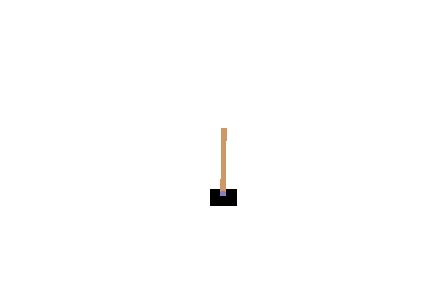
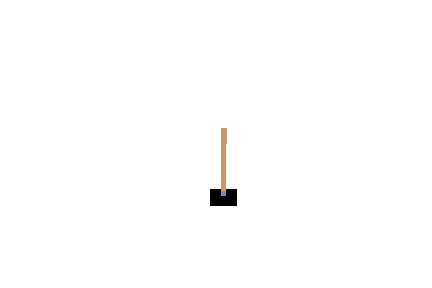
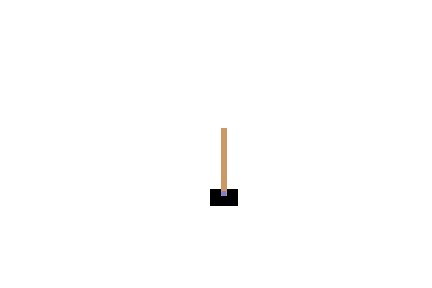
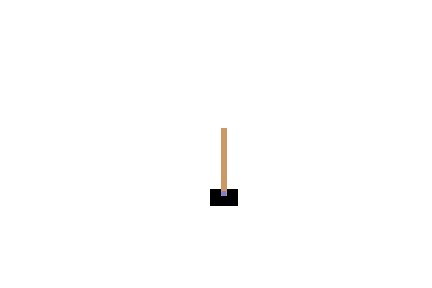
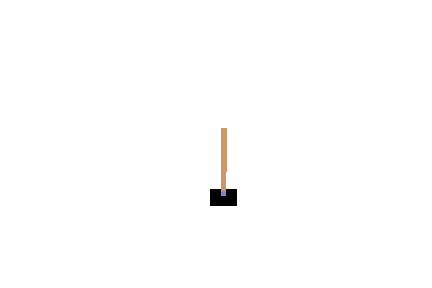
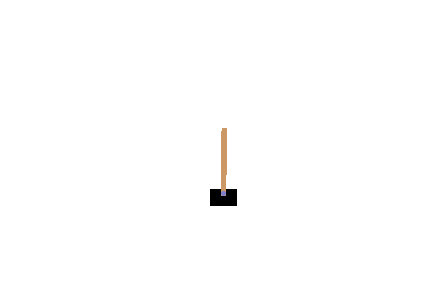
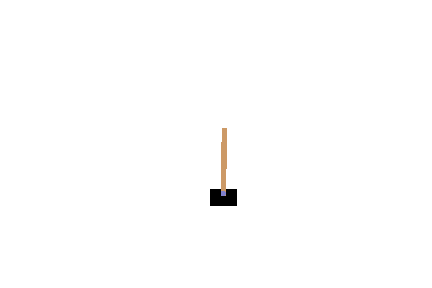
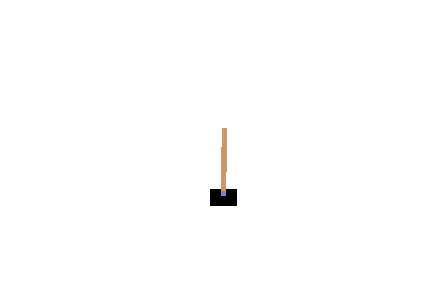
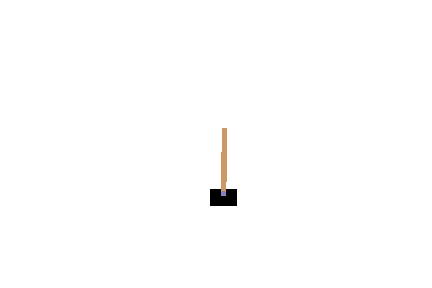
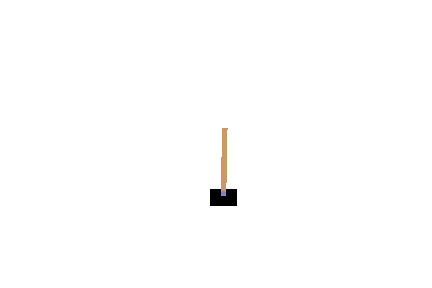
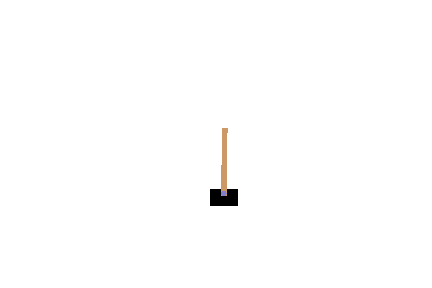
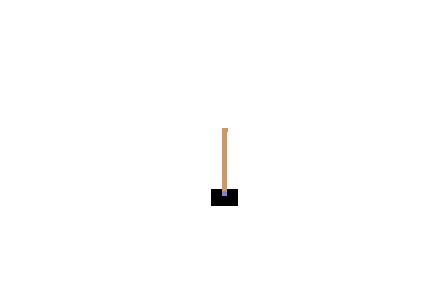
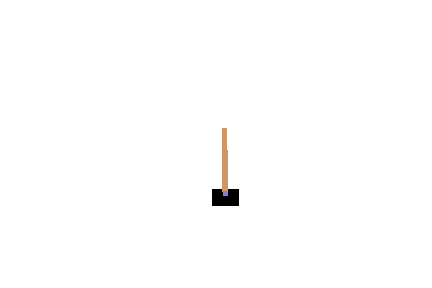
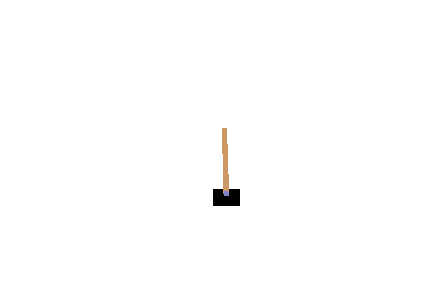
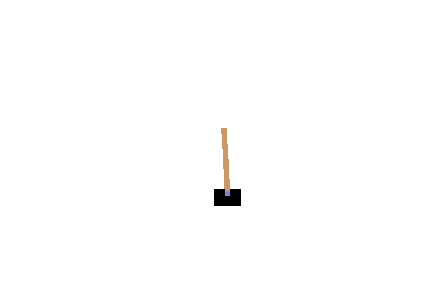
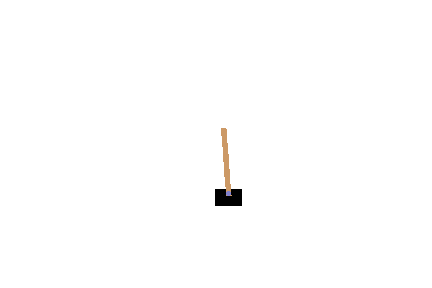
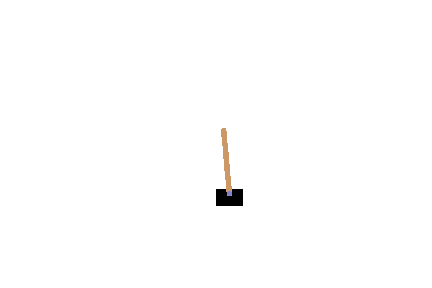
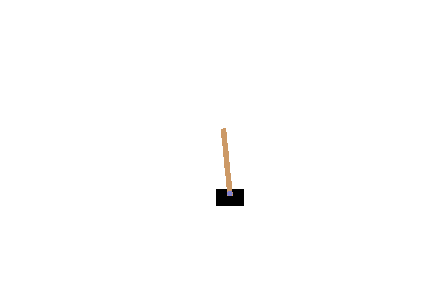
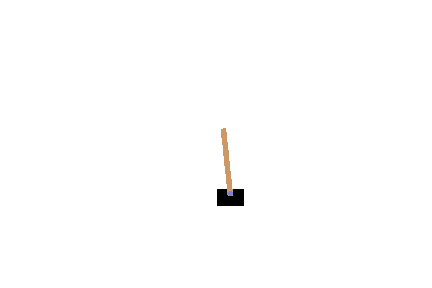
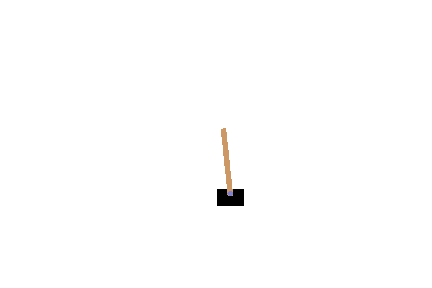
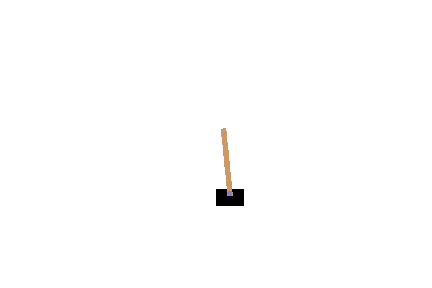
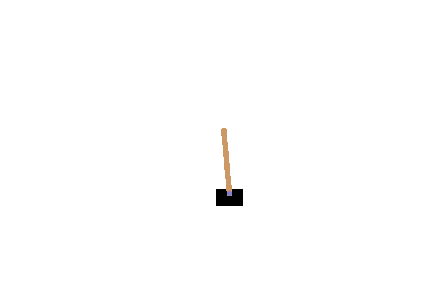
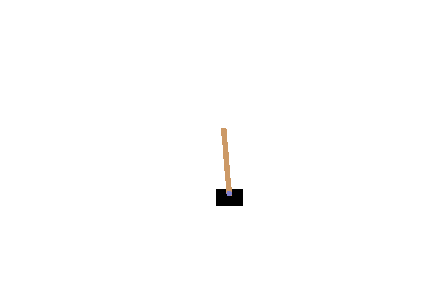
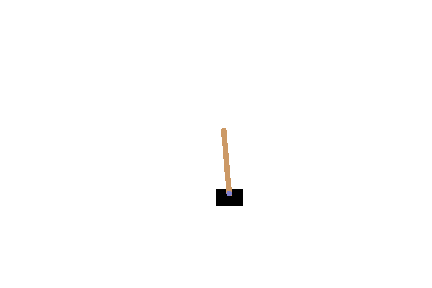
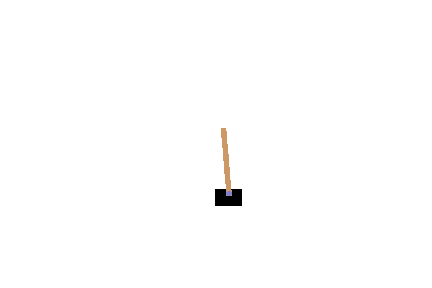
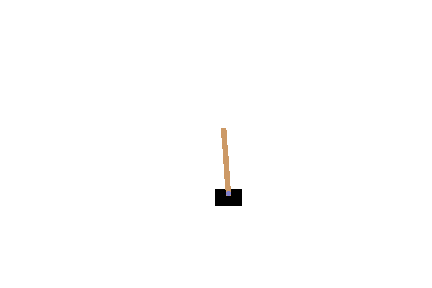
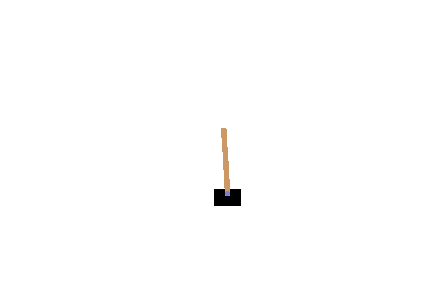
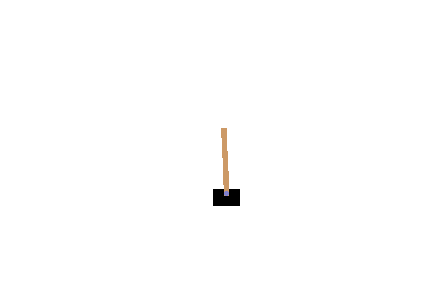
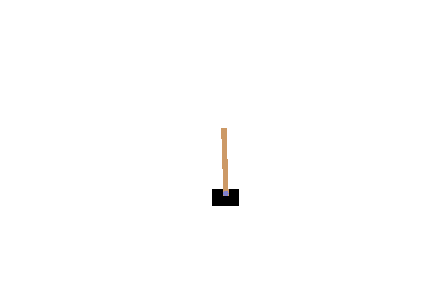
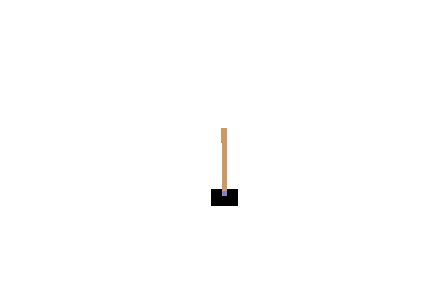
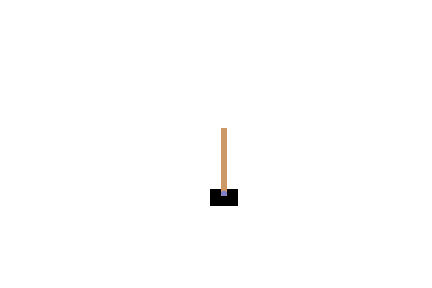
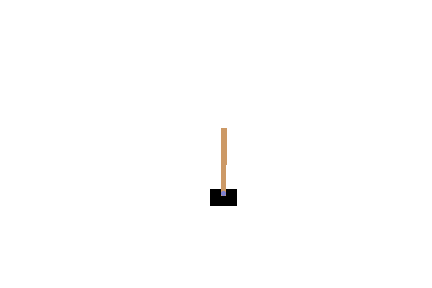
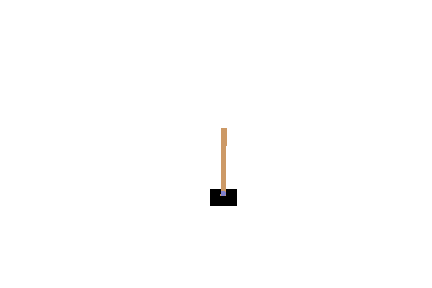
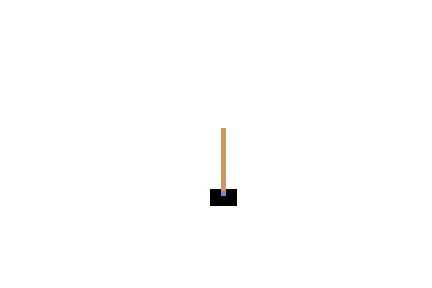
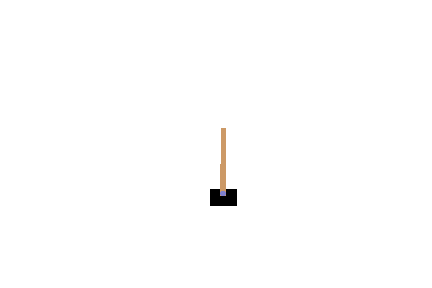
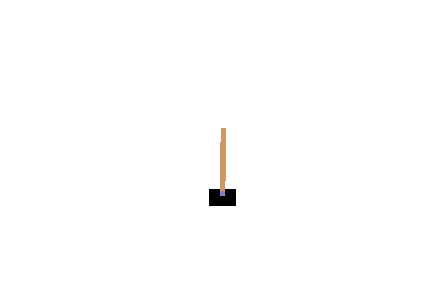
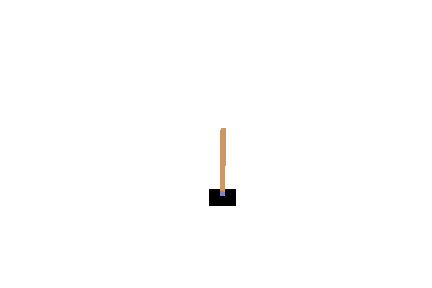
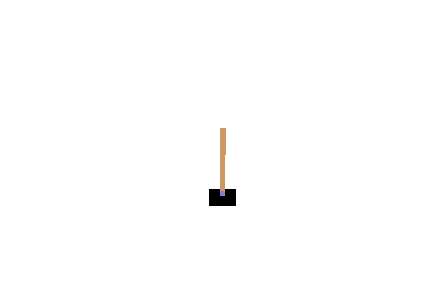
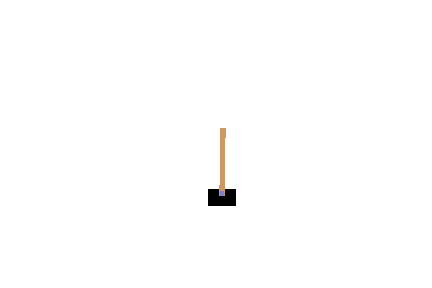
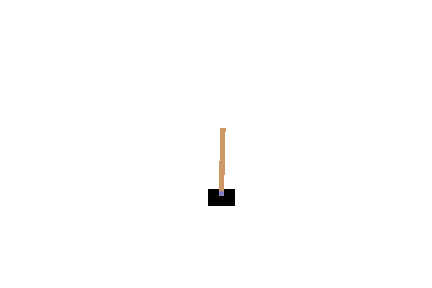
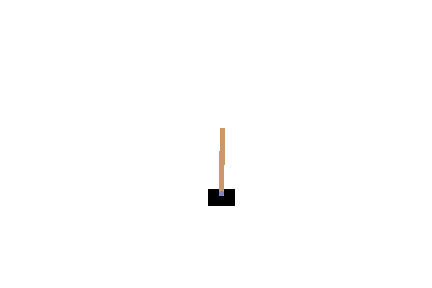
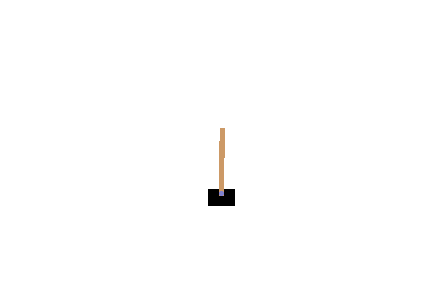
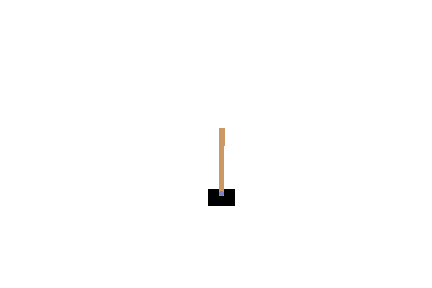
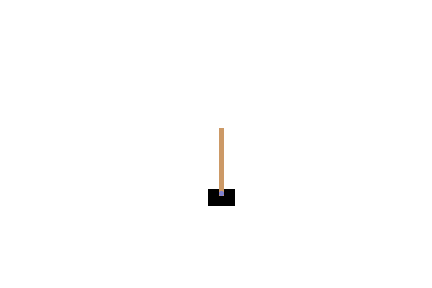
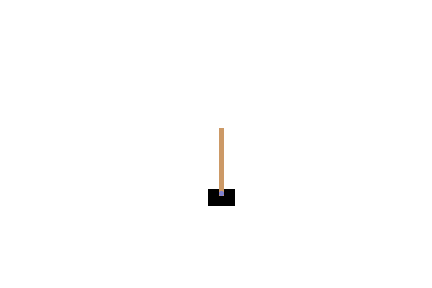
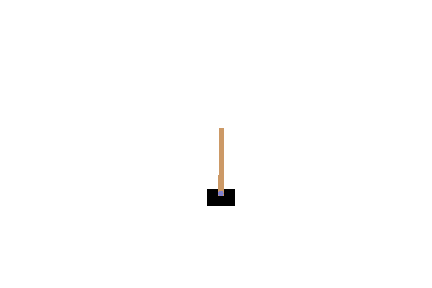
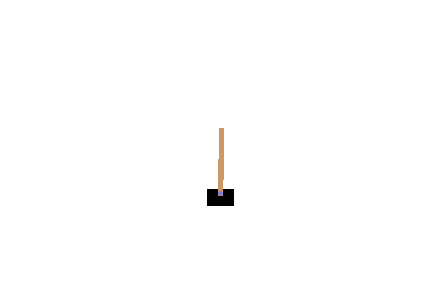
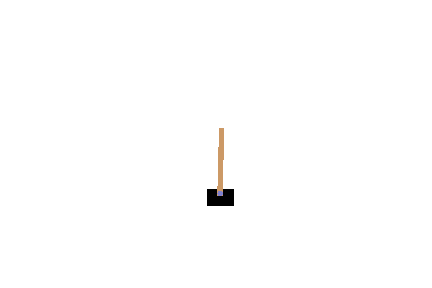
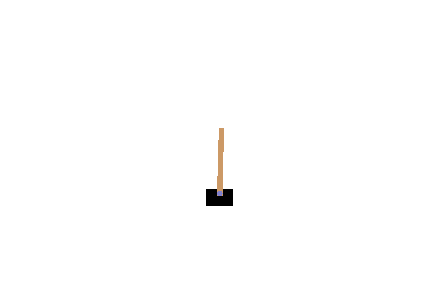
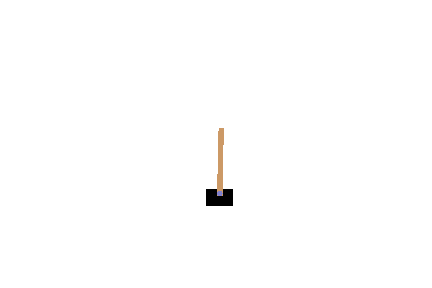
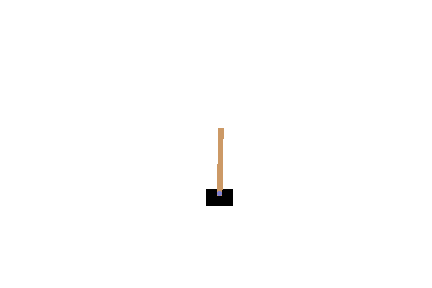
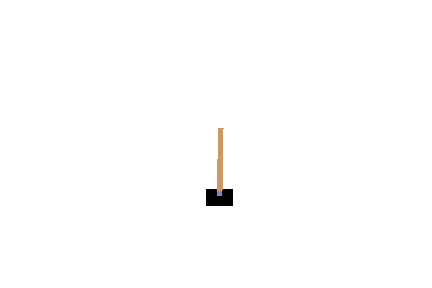
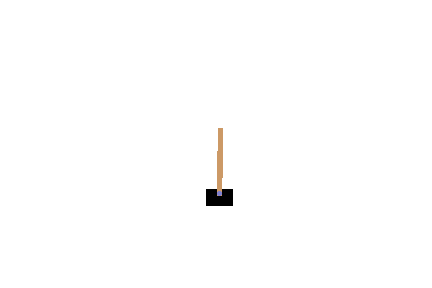
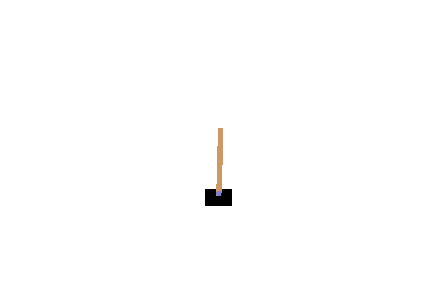
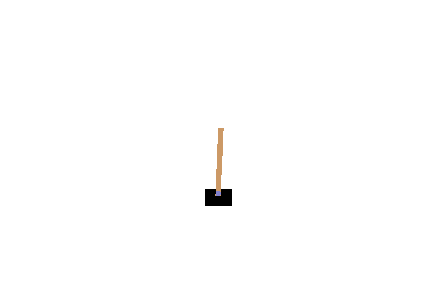
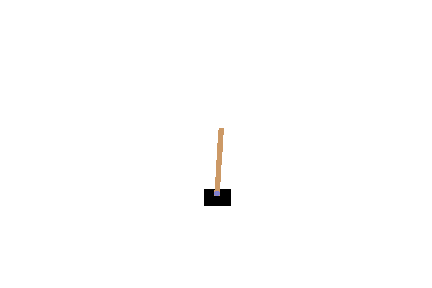
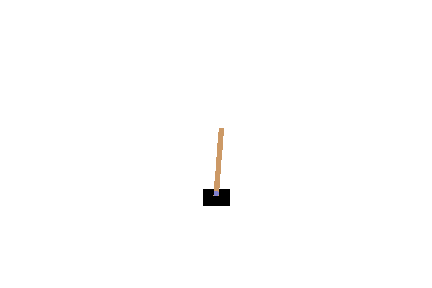
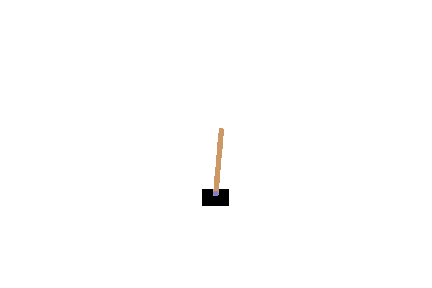
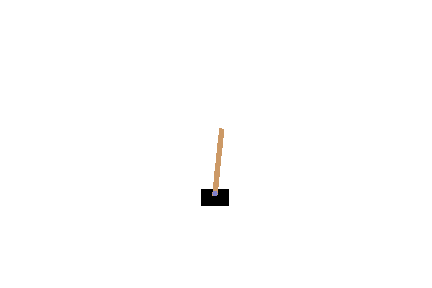
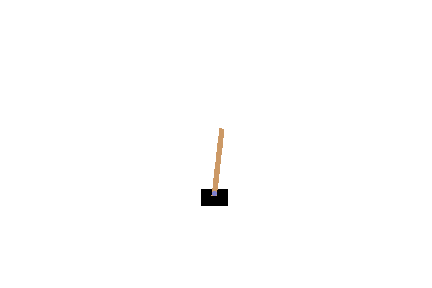
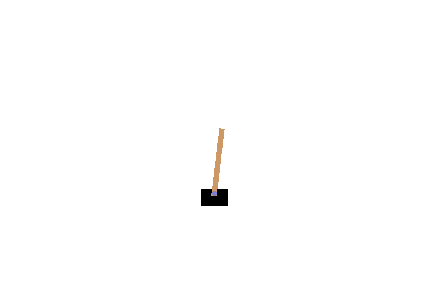
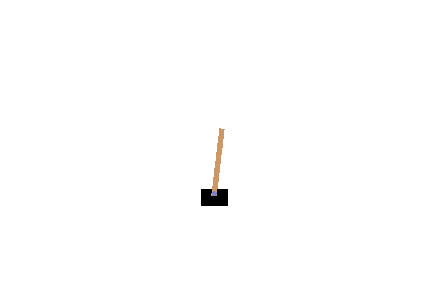
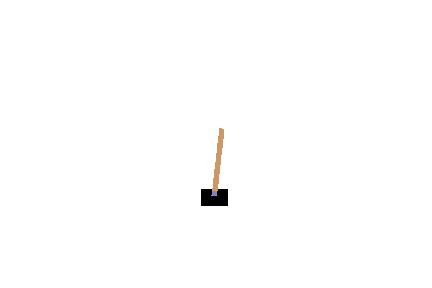
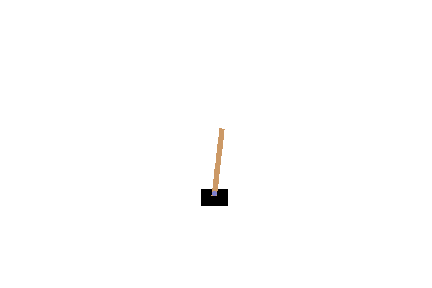
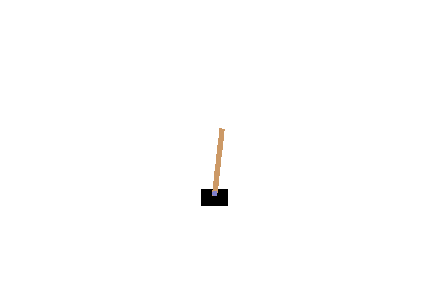
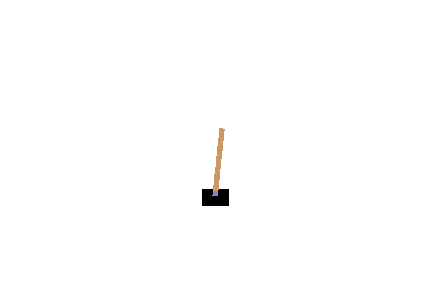
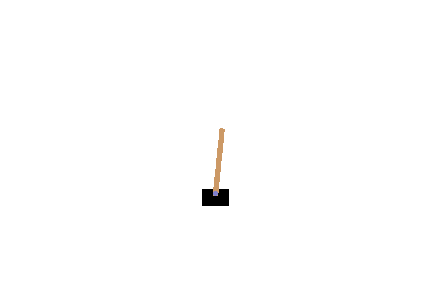
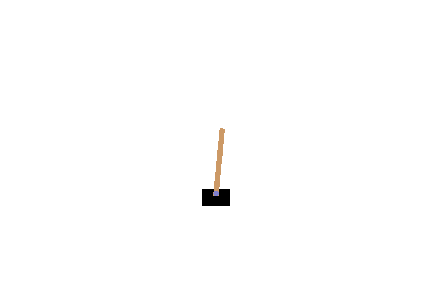
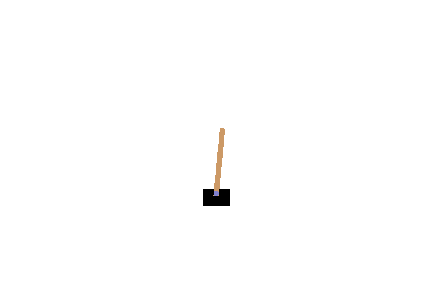
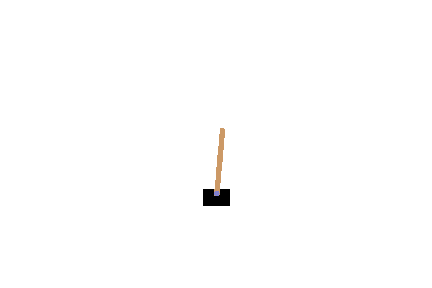
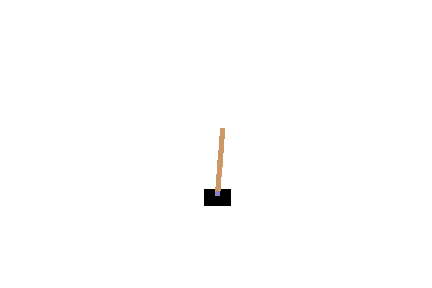
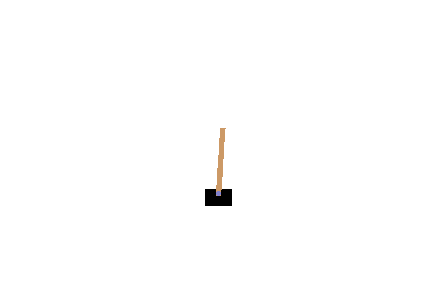
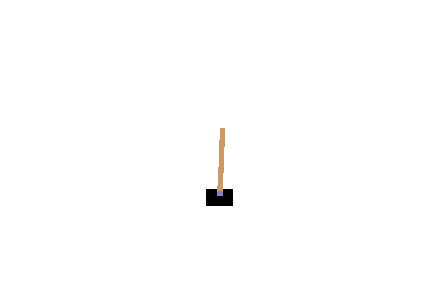
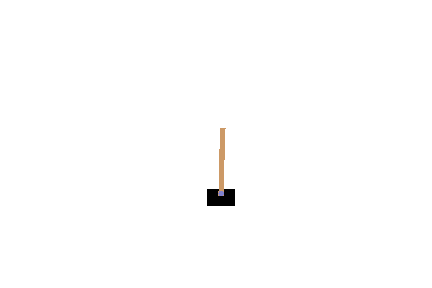
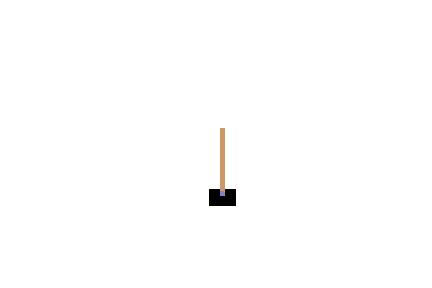
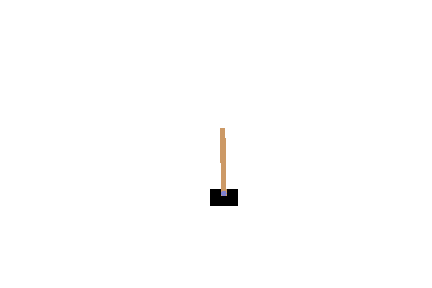
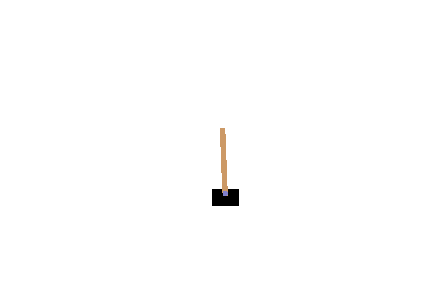
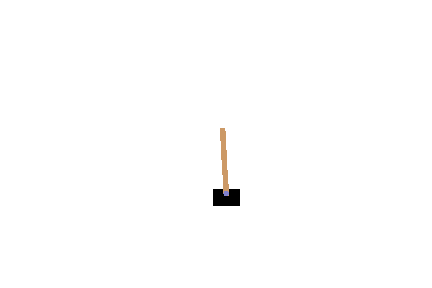
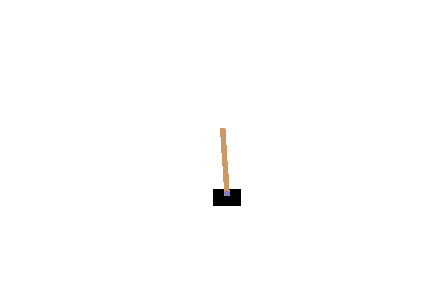
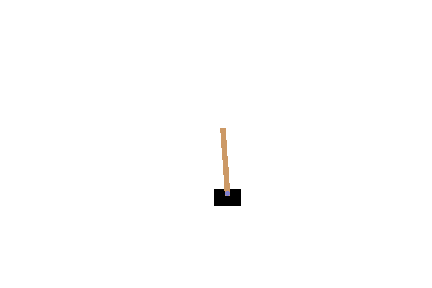
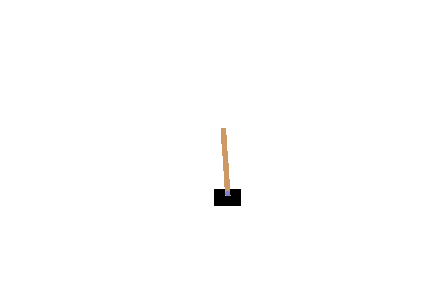
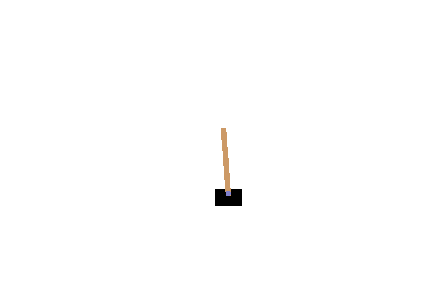
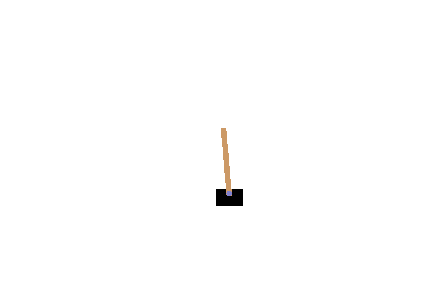
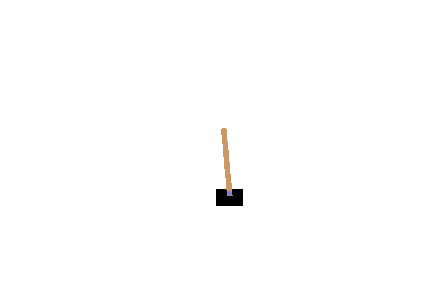
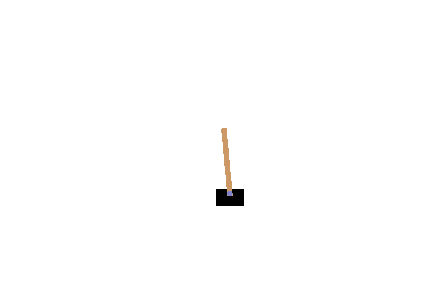
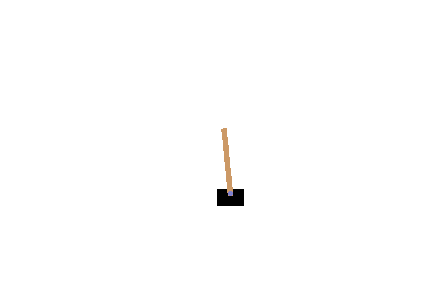
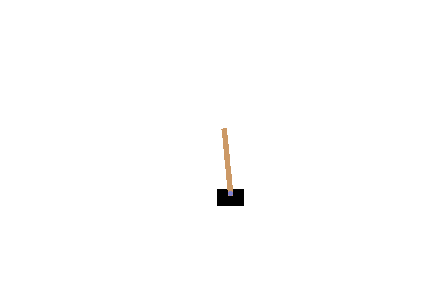
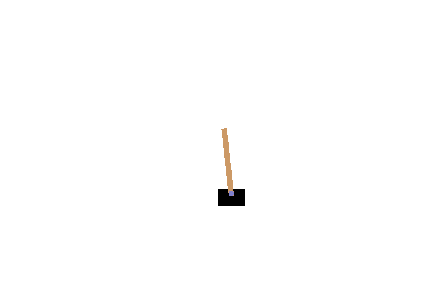
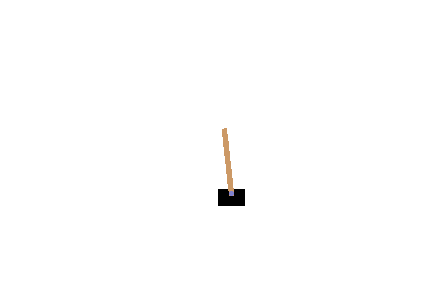
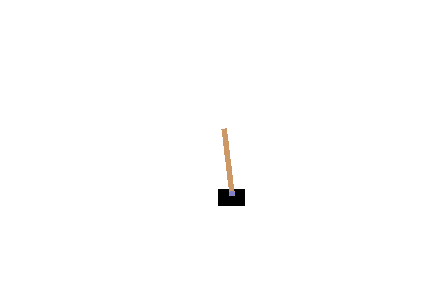
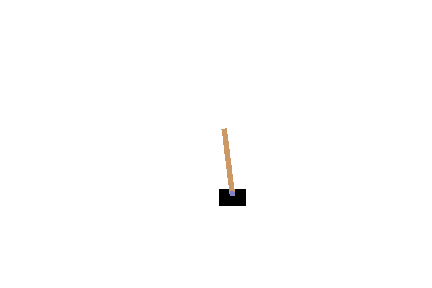
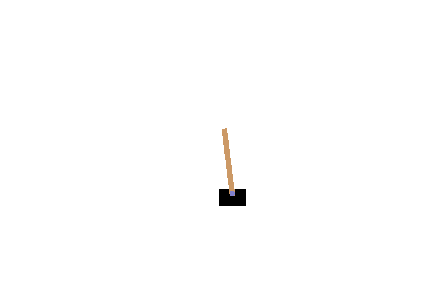
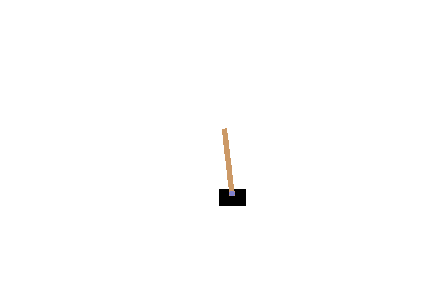
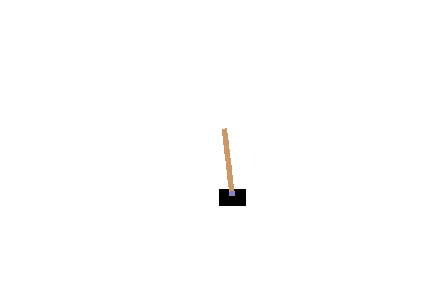
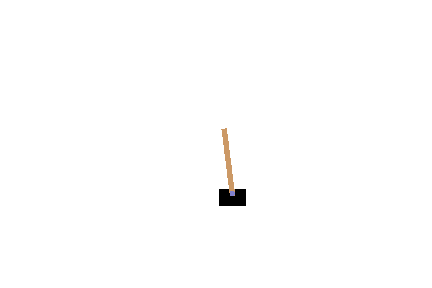
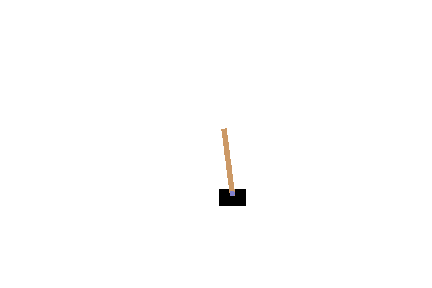
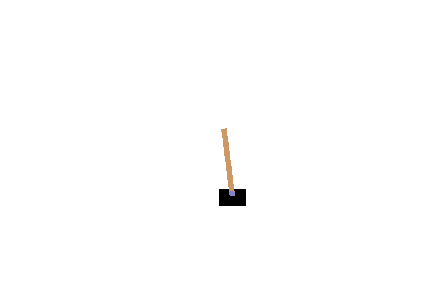
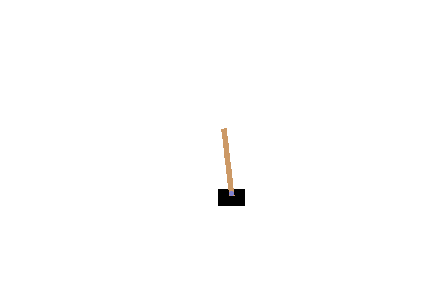
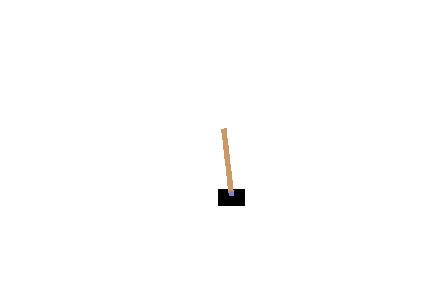
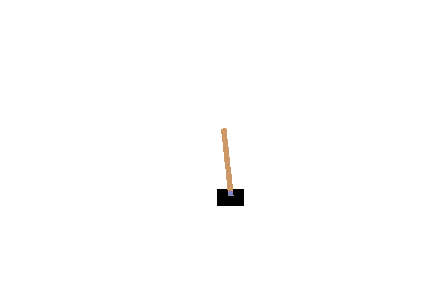
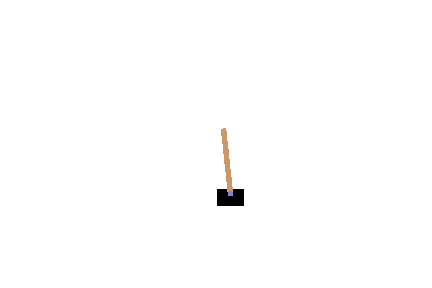
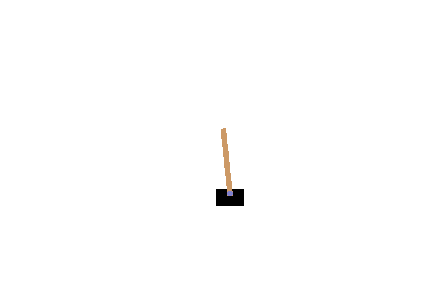
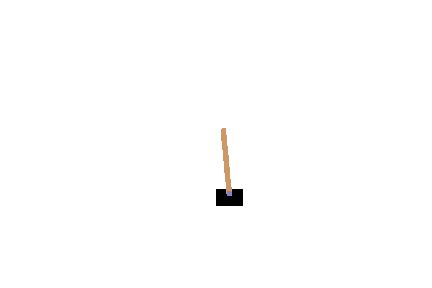
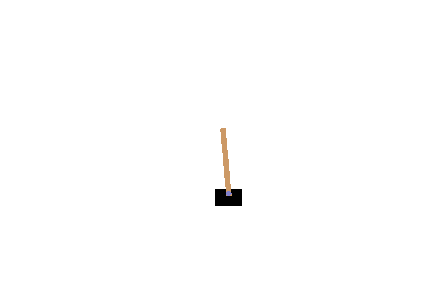
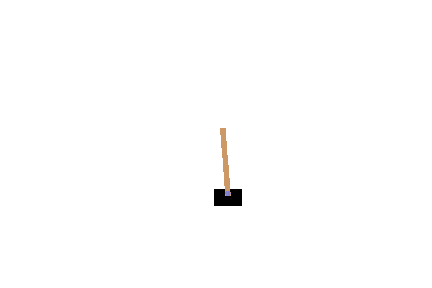
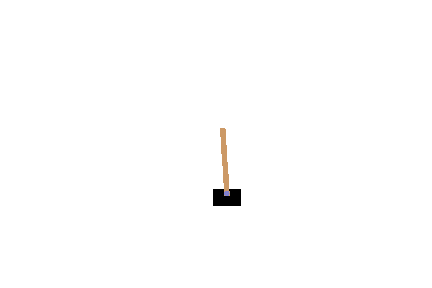
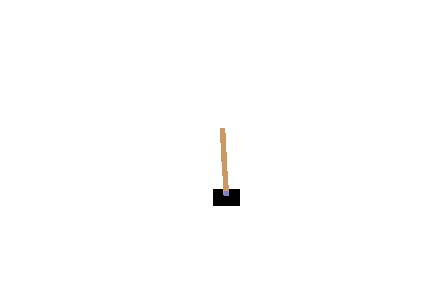
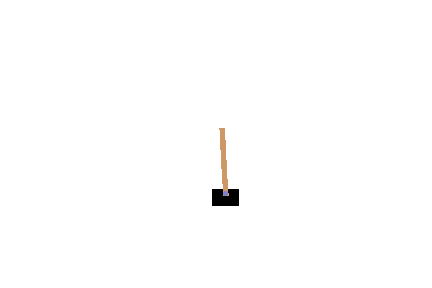
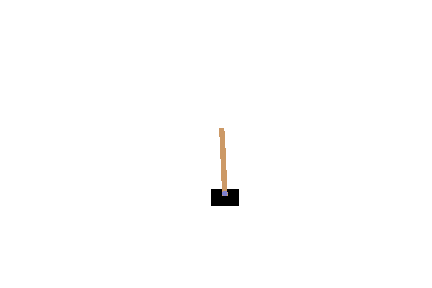
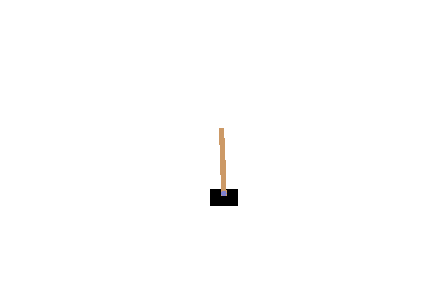
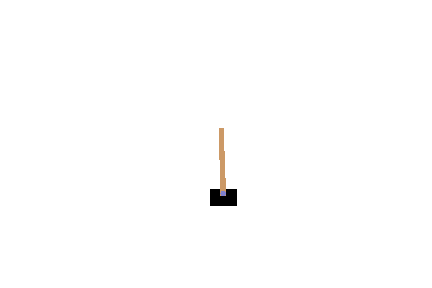
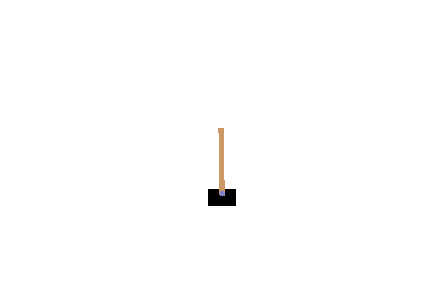
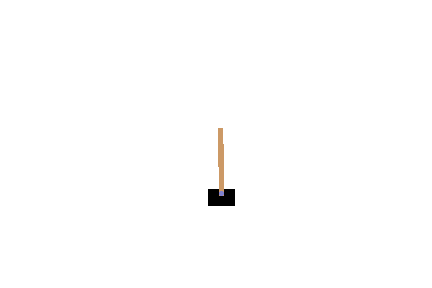
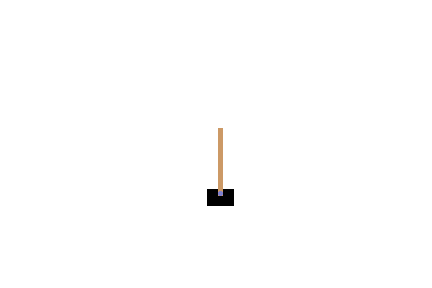
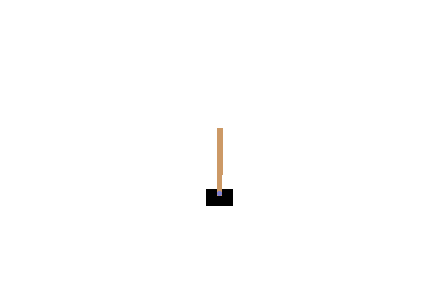
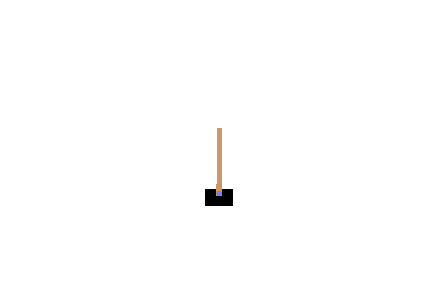
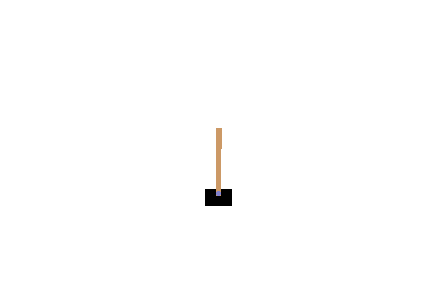
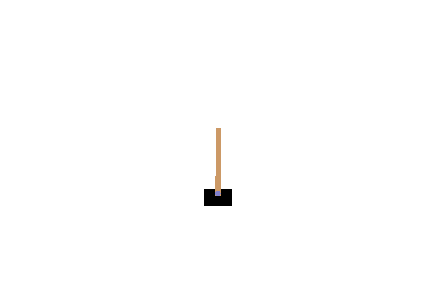
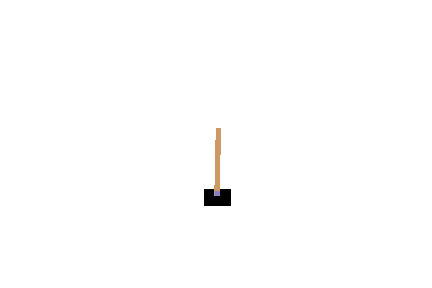
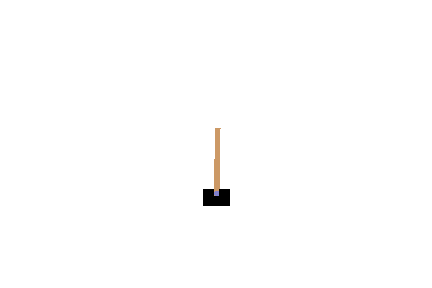
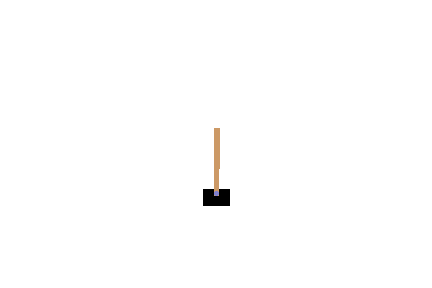
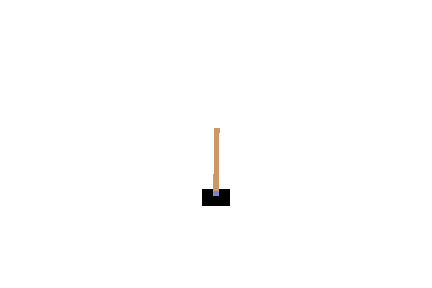
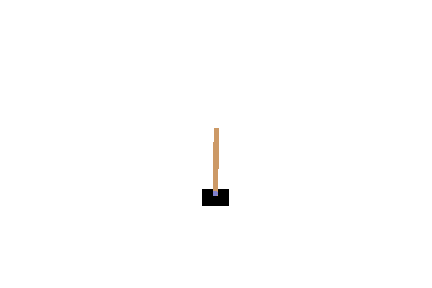
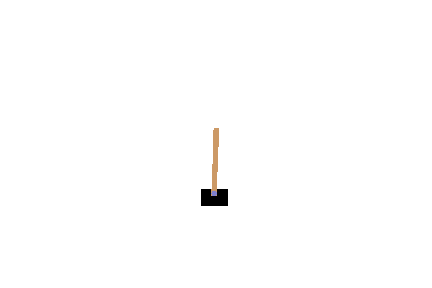
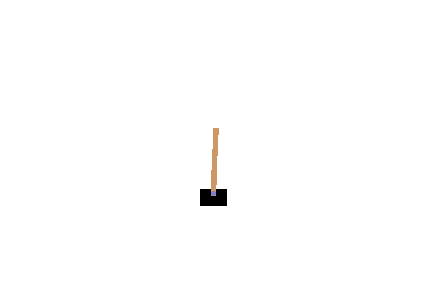
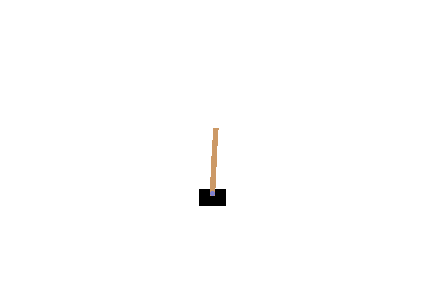
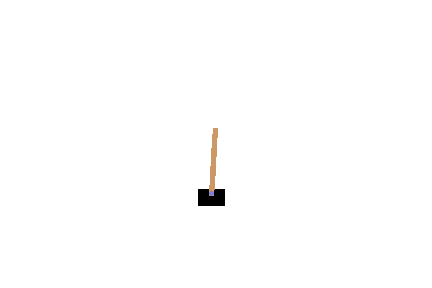
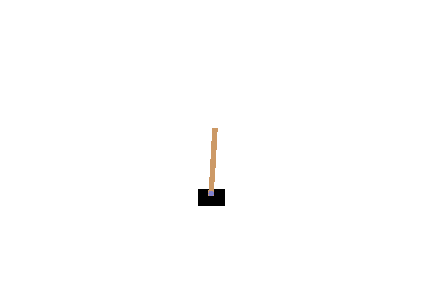
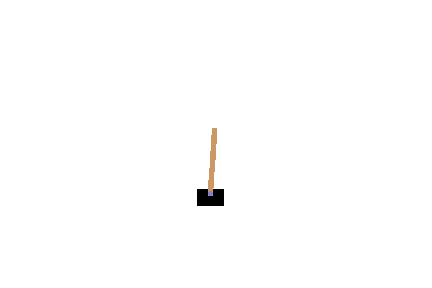
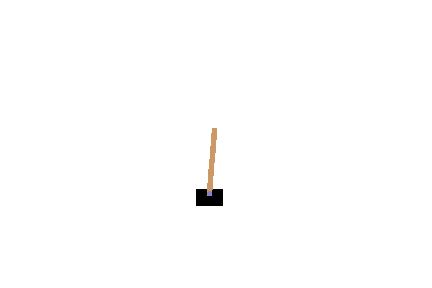
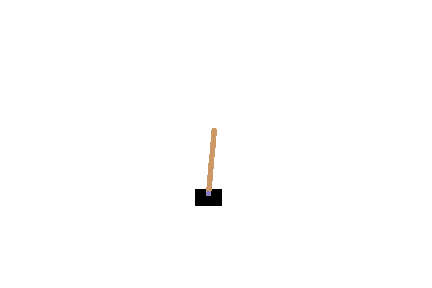
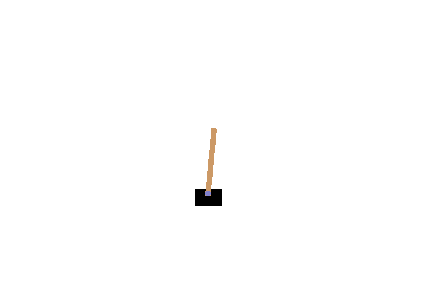
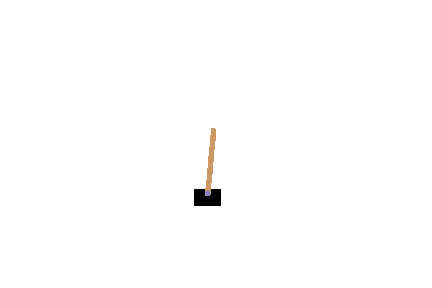
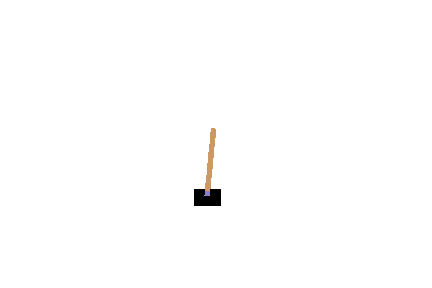
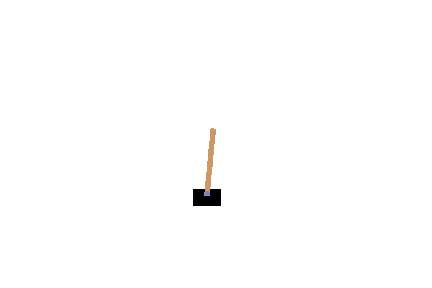
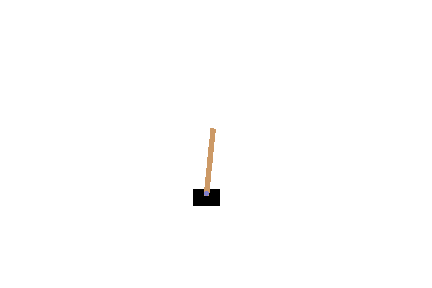
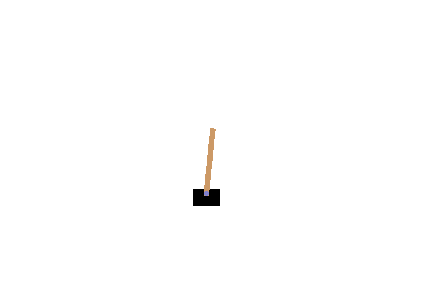
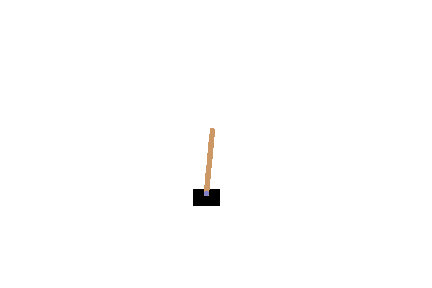
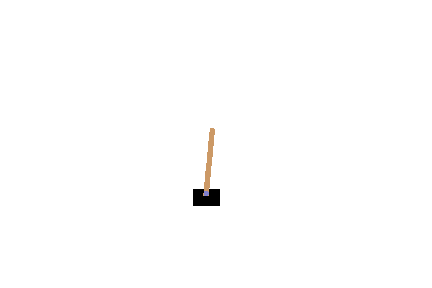
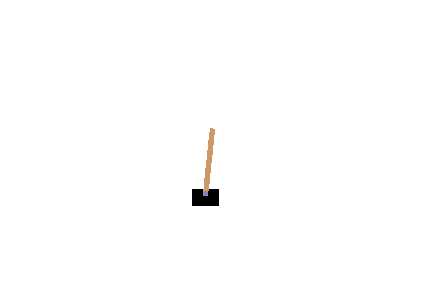
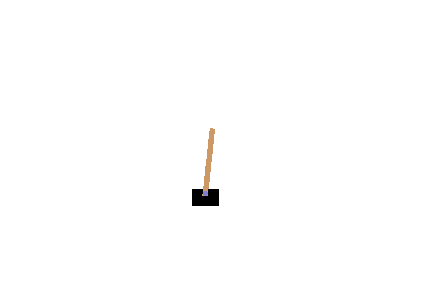
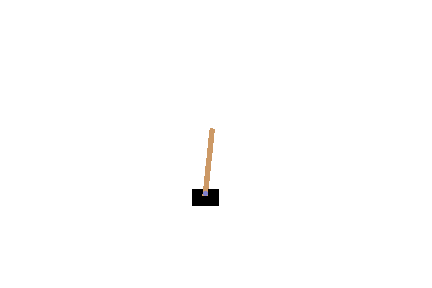
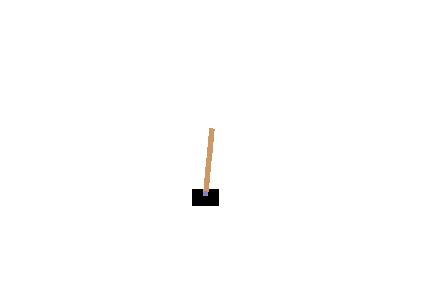
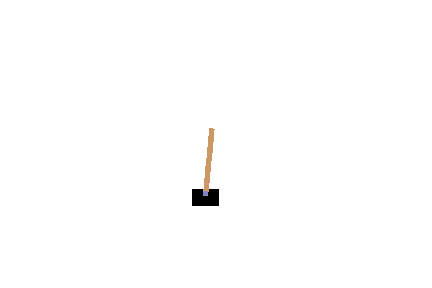
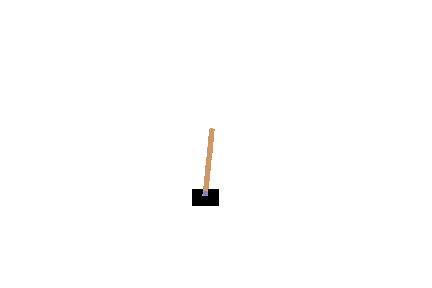
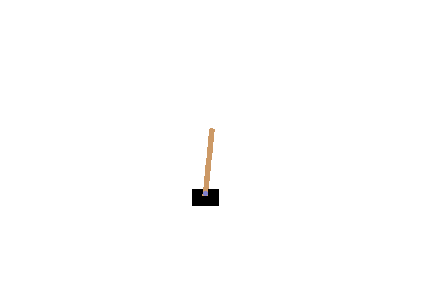
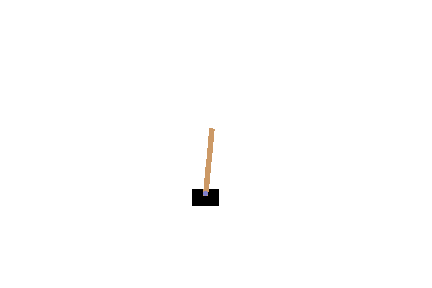
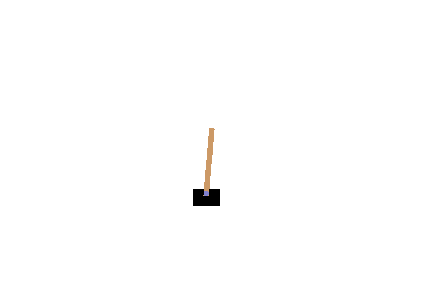
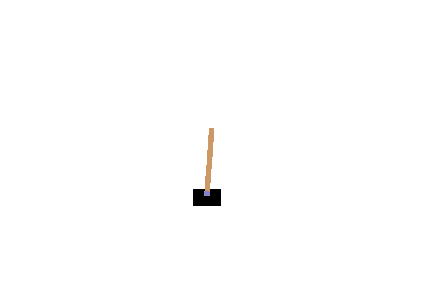
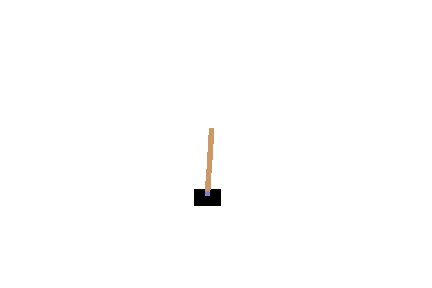
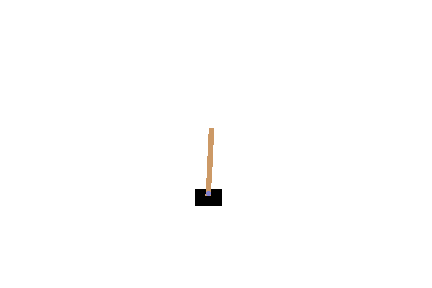
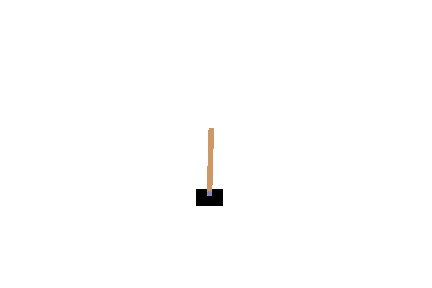
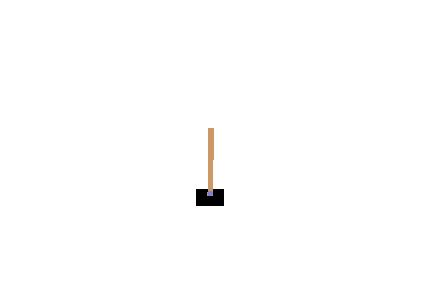
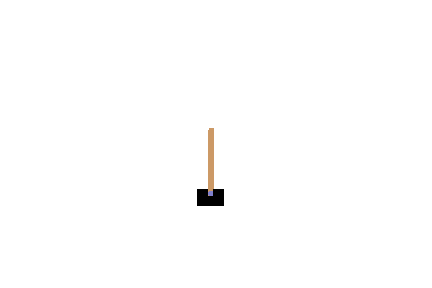
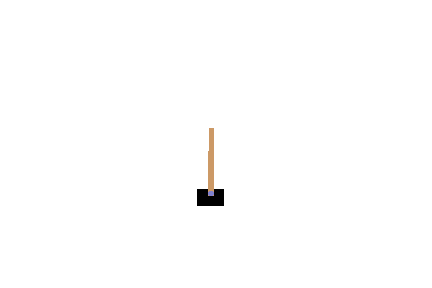
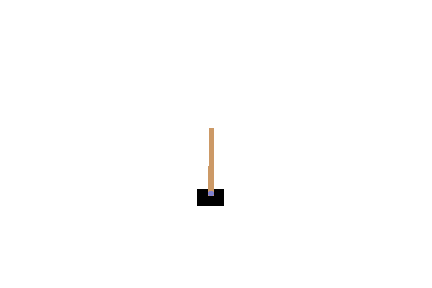
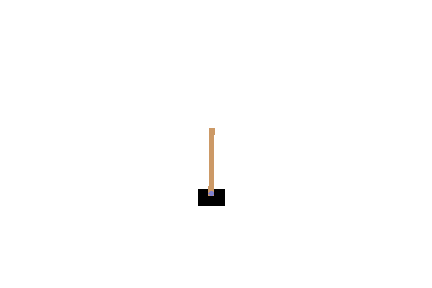
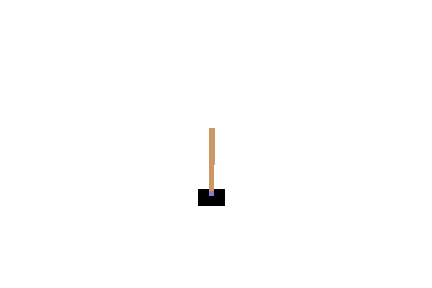
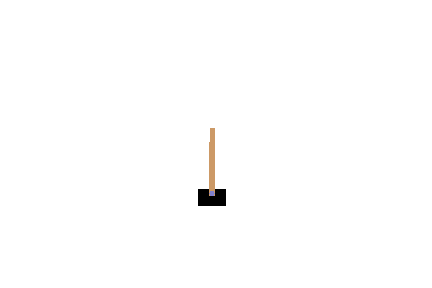
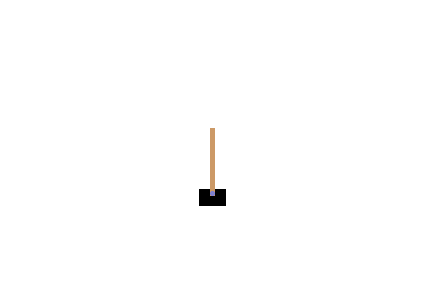
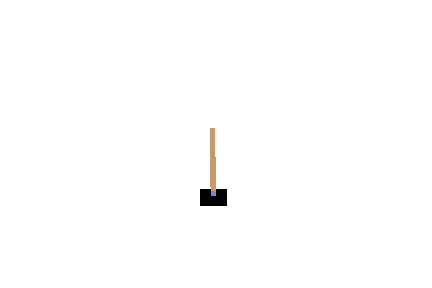
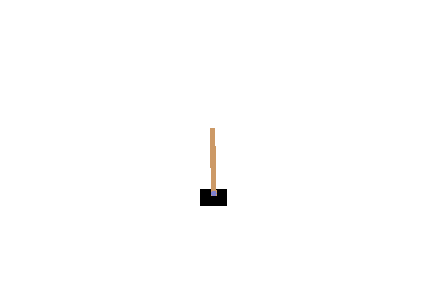
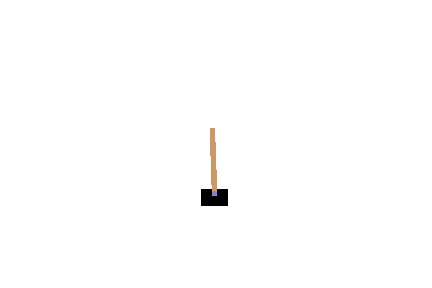
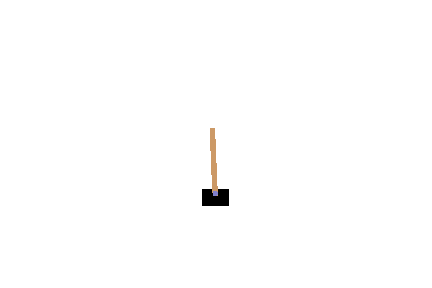
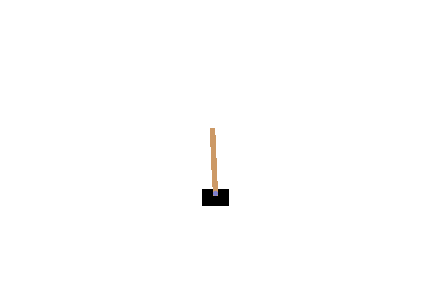
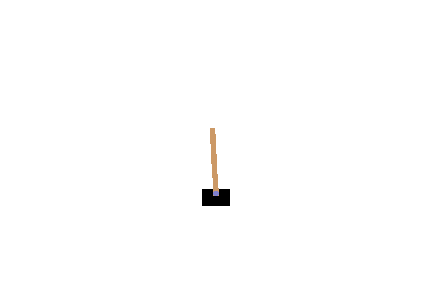
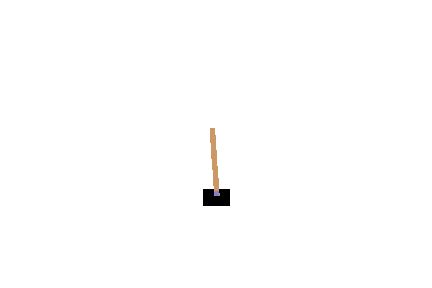
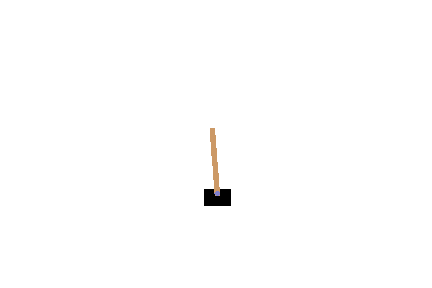
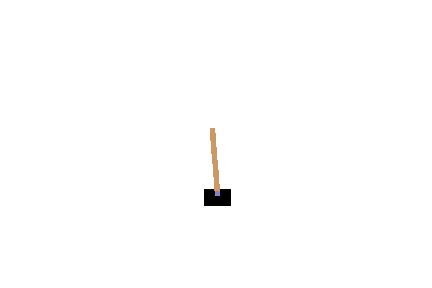
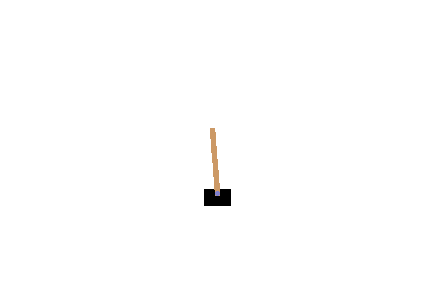
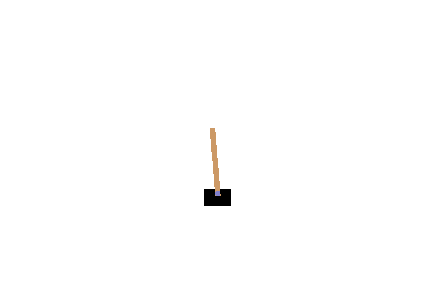
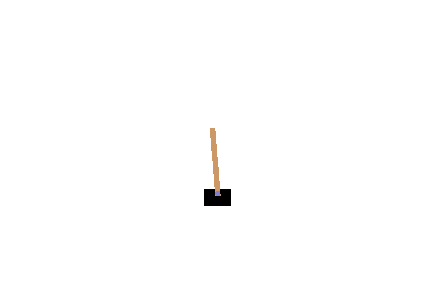
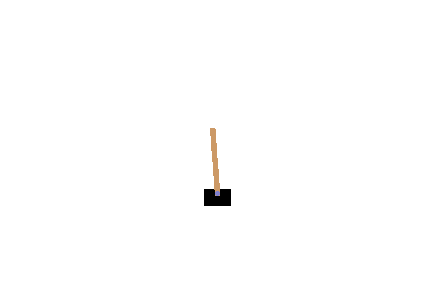
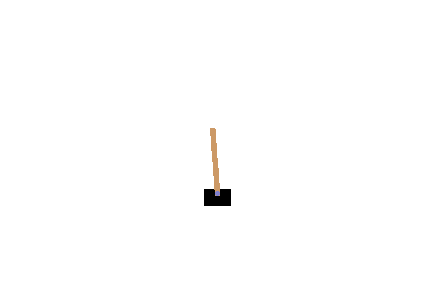
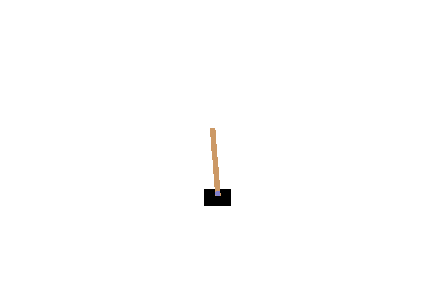
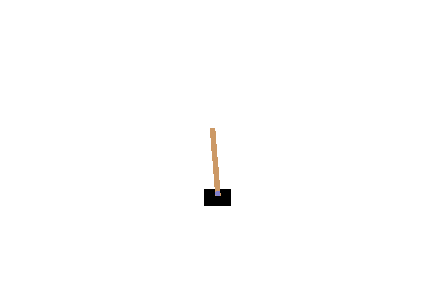
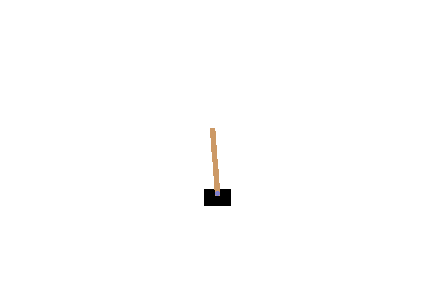
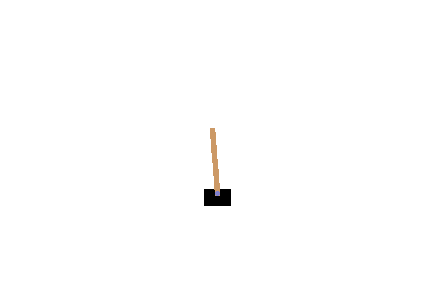
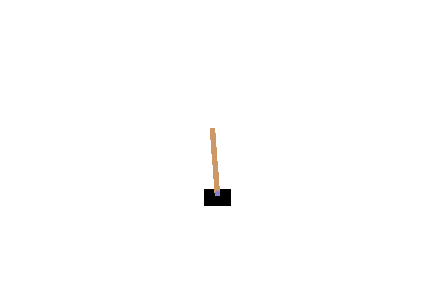
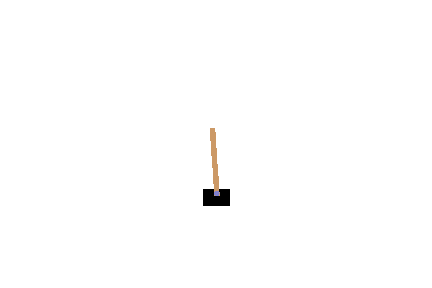
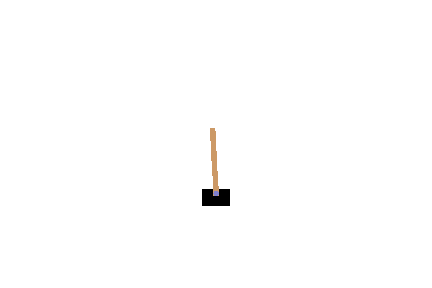
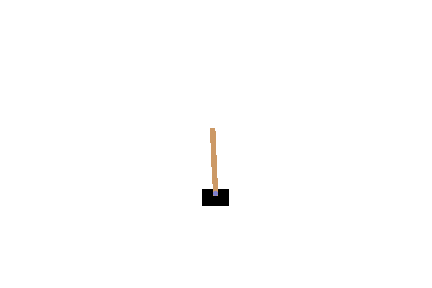

In [16]:
frames = []
state = env.reset()
for t in range(1000):
    action, _ = agent.policy.act(state)
    frames.append(env.render(mode='rgb_array')) 
    state, reward, done, _ = env.step(action)
    if done:
        break

env.close()
animate_frames(frames)